In [1]:
from aux_functions import *

### (Opcional) Extracción de frames

In [2]:
video_path = '/Users/diegosilveracoeff/Downloads/Video_Rami.mp4'
#video_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Lana_Lucho/Lana_Lucho.mp4'
frame_nums = [32, 33]  # Números de frames que deseas extraer
output_folder = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Mountain'

extract_frames(video_path, frame_nums, output_folder)

Frame 32 guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Mountain/frame_32.tif
Frame 33 guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Mountain/frame_33.tif


### Defino rutas de trabajo y cargo imágenes

En las siguientes celdas se importan la imagen de referencia y la imagen objetivo

Valor mínimo de diferencia:  -221
Valor máximo de diferencia:  217
Resultado de la resta ajustado y guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Mountain/residual_frame.tif


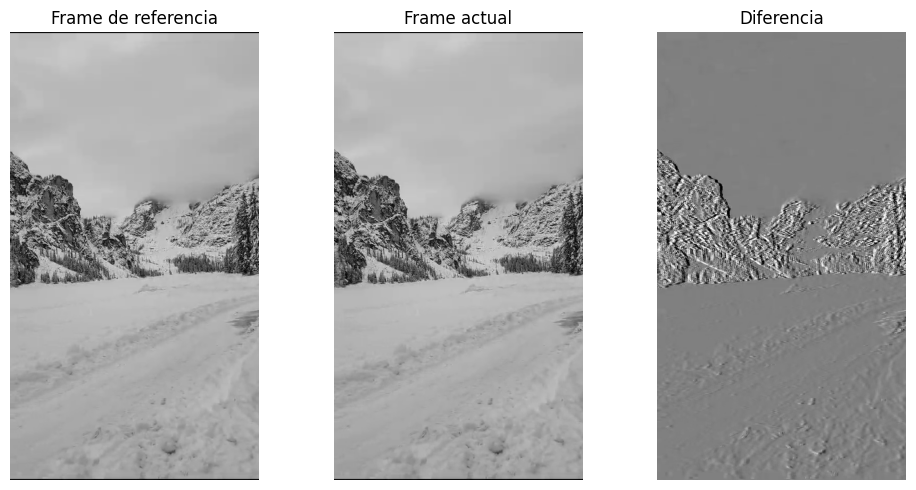

In [3]:
# folder_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian'
# reference_frame_path = os.path.join(folder_path, 'DCM_reference_image.tif')
# current_frame_path = os.path.join(folder_path, 'DCM_7x3_image.tif')
# residual_1_path = os.path.join(folder_path, 'residual_image.tif')

folder_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Mountain'
reference_frame_path = os.path.join(folder_path, 'frame_32.tif')
current_frame_path = os.path.join(folder_path, 'frame_33.tif')
residual_1_path = os.path.join(folder_path, 'residual_frame.tif')

tittles = ['Frame de referencia','Frame actual','Diferencia']

subtract_frames(current_frame_path, reference_frame_path, residual_1_path, clip=True)

plot_three_images(reference_frame_path, current_frame_path, residual_1_path, tittles)

(864, 480, 2)
flow_x guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Mountain/flow_x.npy
flow_y guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Mountain/flow_y.npy
Visualización del flujo óptico guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Mountain/optical_flow_visualization.png


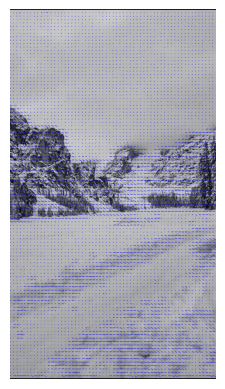

In [4]:
#Calculo el flujo óptico entre el frame de referencia y el frame actual

optical_flow(current_frame_path, reference_frame_path, folder_path)

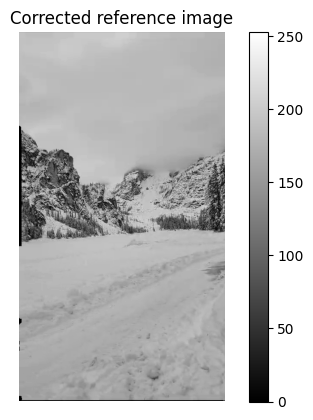

In [5]:
#Cargo el flujo óptico y hago motion_compensation

flow_x_path = os.path.join(folder_path, 'flow_x.npy')
flow_y_path = os.path.join(folder_path, 'flow_y.npy')

def motion_compensation_2(reference_frame_path, current_frame_path, flow_x_path, flow_y_path, output_path):

    curr_frame = cv2.imread(current_frame_path)
    ref_frame = cv2.imread(reference_frame_path)

    # Convertir las imágenes a escala de grises
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    ref_gray = cv2.cvtColor(ref_frame, cv2.COLOR_BGR2GRAY)

    # Cargar los archivos flow_x.npy y flow_y.npy
    flow_x = np.load(flow_x_path)
    flow_y = np.load(flow_y_path)

    corrected_reference = np.zeros_like(curr_gray)
    height, width = corrected_reference.shape

    for i in range(height):
        for j in range(width):
            # Calcular los nuevos índices con el flujo
            new_i = i - round(flow_y[i][j])
            new_j = j - round(flow_x[i][j])

            # Comprobar si los nuevos índices están dentro de los límites
            if 0 <= new_i < height and 0 <= new_j < width:
                corrected_reference[i][j] = ref_gray[new_i][new_j]
            else:
                corrected_reference[i][j] = 0  # O algún valor predeterminado

    cv2.imwrite(output_path, corrected_reference, [cv2.IMWRITE_TIFF_COMPRESSION, 1])

    plt.imshow(corrected_reference, cmap='gray', vmin=0, vmax=np.max(corrected_reference))
    plt.colorbar()
    plt.title('Corrected reference image')
    plt.axis('off')  # Ocultar ejes
    plt.show()
    return


corrected_reference_path = os.path.join(folder_path, 'corrected_reference.tif')
motion_compensation_2(reference_frame_path, current_frame_path, flow_x_path, flow_y_path, corrected_reference_path)

In [6]:
#Celda de control, en las gaussianas sintéticas debería obtener 0s

residual_2_path = os.path.join(folder_path, 'residual_2.tif')
subtract_frames(corrected_reference_path, current_frame_path, residual_2_path)

Valor mínimo de diferencia:  -245
Valor máximo de diferencia:  145
Resultado de la resta ajustado y guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Mountain/residual_2.tif


In [7]:
#Celda de control, la energía del residual que se calculó teniendo en cuentra 
#el motion_compensation debe ser menor.

energy(residual_1_path)
energy(residual_2_path)

La energía de residual_frame.tif es 102645978
La energía de residual_2.tif es 86375793


### Transformada coseno y cuantización

In [12]:
#Calculo la DCT del residual y cuantizo
def dct_2(image_path, output_path):
    #Leo imagen 
    img_to_transform = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.int16)

    width, height = img_to_transform.shape
    dct_img = np.empty((width, height),dtype=int)


    for x in range(0, width, 8):
        for y in range(0, height, 8):
            block = np.array(img_to_transform[x:x+8,y:y+8], dtype=int)
            #print(block.shape)
            #print('x,y: ',x,y)
            dct_block = dctn(block, norm='ortho')  # DCT tipo 2
            dct_img[x:x+8,y:y+8] = dct_block
    # Ejemplo de cálculo de la DCT
    #dct_img = dctn(img_to_transform, norm='ortho')  # DCT tipo 2
    cv2.imwrite(output_path, dct_img)
    return dct_img

dct_path = os.path.join(folder_path, 'DCT.tif')
q_path = os.path.join(folder_path, 'quantized_image.tif')

dct_image = dct_2(residual_2_path, dct_path)
q_image, q_array = quantization(dct_image, 10, q_path)

#print(q_array)

#plot_one_img(dct_path)

In [18]:
def reorder_array(arr):
    result = []
    n = len(arr)
    zero_count = 0
    for i in range(n):
        if arr[i] != 0:
            if i < n - 1 and np.any(arr[i+1:] != 0):
                flag = 0
            else:
                flag = 1
            result.append((zero_count, arr[i], flag))
            zero_count = 0
        else:
            zero_count += 1
    return np.array(result, dtype=[('zero_count', 'i4'), ('value', 'i4'), ('flag', 'i4')])

def reconstruct_array(array_salida, original_length):
    reconstructed_array = np.zeros(original_length, dtype=int)
    index = 0
    for zero_count, value, flag in array_salida:
        index += zero_count
        reconstructed_array[index] = value
        index += 1
    return reconstructed_array

reordered_array = reorder_array(q_array)

print(reordered_array)
# #Despues de cuantizar hago el reordenamiento y recorte de ceros
# reorder_image = encoder_reorder(q_image)
# print(len(reorder_image))
# print(reorder_image[-3])
# trimmed_array, zeros_removed = trim_zeros(reorder_image)

# print(trimmed_array.shape)
# print(zeros_removed)


[(0, 1020, 0) (7, 1020, 0) (7, 1000, 0) ... (1,   10, 0) (1,  -10, 0)
 (1,   10, 1)]


In [14]:
#Calculo la probabilidad de ocurrencia de cada valor de la DCT cuantizada y armo el codebook

count = count_pixel_values(reordered_array)
print(count)
print(len(count))
symbols, codes = huffman_codebook(count)

np.save(os.path.join(folder_path,'symbols.npy'), symbols)
print(f"symbols guardados como {os.path.join(folder_path,'symbols.npy')}")
np.save(os.path.join(folder_path,'codes.npy'), codes)
print(f"codes guardado como {os.path.join(folder_path,'codes.npy')}")

[('(0, -410, 0)', 1), ('(0, -360, 0)', 1), ('(0, -330, 0)', 1), ('(0, -320, 0)', 3), ('(0, -310, 0)', 1), ('(0, -300, 0)', 2), ('(0, -290, 0)', 1), ('(0, -280, 0)', 2), ('(0, -270, 0)', 3), ('(0, -250, 0)', 1), ('(0, -240, 0)', 1), ('(0, -230, 0)', 4), ('(0, -220, 0)', 5), ('(0, -210, 0)', 2), ('(0, -200, 0)', 2), ('(0, -180, 0)', 2), ('(0, -170, 0)', 3), ('(0, -160, 0)', 3), ('(0, -150, 0)', 7), ('(0, -140, 0)', 9), ('(0, -130, 0)', 9), ('(0, -120, 0)', 20), ('(0, -110, 0)', 30), ('(0, -100, 0)', 54), ('(0, -90, 0)', 87), ('(0, -80, 0)', 205), ('(0, -70, 0)', 251), ('(0, -60, 0)', 529), ('(0, -50, 0)', 603), ('(0, -40, 0)', 1050), ('(0, -30, 0)', 1501), ('(0, -20, 0)', 3558), ('(0, -10, 0)', 6429), ('(0, 10, 0)', 6387), ('(0, 20, 0)', 3489), ('(0, 30, 0)', 1435), ('(0, 40, 0)', 1034), ('(0, 50, 0)', 643), ('(0, 60, 0)', 509), ('(0, 70, 0)', 256), ('(0, 80, 0)', 168), ('(0, 90, 0)', 88), ('(0, 100, 0)', 50), ('(0, 110, 0)', 29), ('(0, 120, 0)', 15), ('(0, 130, 0)', 5), ('(0, 140, 0)', 

In [15]:
#Sustituyo cada símbolo por su código y escribo el archivo con el fillout_number

def write_encoded_file_2(reordered_array, symbols, codes, output_path):
    '''
    '''
    encoded_file = ''

    for i in range(len(reordered_array)):
        # print(reordered_array[i])
        # print(symbols)
        j = np.where(symbols == str(reordered_array[i]))
        # print(j)
        encoded_file = encoded_file + codes[j[0][0]]
    print('Largo de la imagen codificada (mensaje)', len(encoded_file))
    bytes_to_write = add_fillout_number(encoded_file)
    with open(output_path, 'wb') as f:
        # Convertir la cadena de bits en una secuencia de bytes
        final_bytes = int(bytes_to_write, 2).to_bytes((len(bytes_to_write) + 7) // 8, byteorder='big')
        f.write(final_bytes)
    return

bin_path = os.path.join(folder_path, 'message.bin')
write_encoded_file_2(reordered_array, symbols, codes, bin_path)

Largo de la imagen codificada (mensaje) 276017
Fillout_number:  7
0000011100000001111000110101000001101000001101000001101000001101000001101000001101000001101000001101010010110100101101010101010101010110100110100110100110100110100110100110100110100110100110100110100110100100101101001011010010110100101101001011010010110110100101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101001111101010010100000110100000110100000110100000110100000110100000110100000110101111111010010110100101101010101010101010110100110100110100110100110100110100110100110100110100110100110100110100100101101001011010010110100101101001011010010110110100101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101001001111001110100010110110101101101011011010110110100000011000010000001001100011010101101001101001001011010010110101010101010110100101011010010101010110100101010101010101010101001011010010110110100110100100101101001011010101010101